In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
#constant time variables
dt = 1e-5
t = np.arange(0, .5, dt)

In [10]:
f1 = lambda x1, lmbda: (.0001)*lmbda*(1-(x1)) - 279.6*(x1)
f2 = lambda x1, x2, x3: 150.5*(x1)*(1-x2-x3) - 819.8*x2 - 30*x2*x3
f3 = lambda x2, x3: -819.8*x3 + 4.51*x2

def step_function(a, t):
    z = np.zeros_like(t)
    for i in range(len(t)):
        if (t[i] <= .125):
            z[i] = a*.001
        elif (.125 < t[i] <= .25):
            z[i] = a
        elif (.25 < t[i] <= .375):
            z[i] = a*1e5
        else:
            z[i] = a*1e7
    return z

#diffeq solver w/ euler's forward method
def forward_euler(lmbda, t): #should dt be 10^-5 here?
    x1 = np.zeros_like(t)
    x2 = np.zeros_like(t)
    x3 = np.zeros_like(t)
    x1[0], x2[0], x3[0] = 1, 0, 0
    
    for i in range(len(t)-1):
        x1[i+1] = x1[i] + (f1(x1[i], lmbda[i]))*dt
        x2[i+1] = x2[i] + (f2(x1[i],x2[i],x3[i]))*dt
        x3[i+1] = x3[i] + (f3(x2[i],x3[i]))*dt
        
    return x2

In [11]:
import numpy as np

def zo(x):
    return np.minimum(np.maximum(0., x), 1.)

class HodgkinHuxley:
    def __init__(self):
        """ Init function for a Hodgkin-Huxley neuron."""
        self.x = [0., 0.3178, 0.0530, 0.5958, 0., 0., 0.]
    def step(self,dt,I,x=None):
        """Step function for a Hodgkin-Huxley neuron
        Parameters
        --------
        dt: float
            Time step in seconds
        I: float
            Injected current
        x: list
            State list, containing:
            V: float
                Current voltage
            n: float
                Current state variable value
            m: float
                Current state variable value
            h: float
                Current state variable value
            spike: float
                Current binary spike state
            Vprev1: float
                Voltage 1 time step ago
            Vprev2: float
                Voltage 2 time steps ago
        Returns
        -------
        x: list
            Updated state list.
        """

        dt = dt * 1000.
        I = I
        if x is None:
            x = self.x
        V, n, m, h, spike, Vprev1, Vprev2 = self.x

        n = zo(n)
        m = zo(m)
        h = zo(h)

        E_K = -77
        E_Na = 50
        E_L = -54.387
        gmax_K = 36
        gmax_Na = 120
        g_L = 0.3

        an = 0.01*(V+55)/(1-np.exp(-0.1*(V+55)))
        bn = 0.125*np.exp(-(V+65)/80)


        am = 0.1*(V+40)/(1-np.exp(-0.1*(V+40)))
        bm = 4*np.exp(-(V+65)/18)


        ah = 0.07*np.exp(-0.05*(V+65))
        bh = 1/(1+np.exp(-0.1*(V+35)))

        # Update internal state variables
        dn = (an*(1.-n)-bn*n)
        dm = (am*(1.-m)-bm*m)
        dh = (ah*(1.-h)-bh*h)

        # Calculate the memconductances
        g_K = gmax_K*(n**4.)
        g_Na = gmax_Na*(m**3.)*h

        # Update the ionic currents: and membrane voltage:
        I_K = g_K*(V-E_K)
        I_Na = g_Na*(V-E_Na)
        I_L = g_L*(V-E_L)

        # Calculate the gradients
        dV = I-I_K-I_Na-I_L
        spike = (Vprev2<=Vprev1) * (Vprev1 >= V) * (Vprev1 > -30)
        x = [V+dt*dV, n+dt*dn, m+dt*dm, h+dt*dh, spike, V+dt*dV, Vprev1]
        self.x = x
        return x

In [12]:
lmbda = step_function(2, t) #step function for lambda values
x2 = forward_euler(lmbda, t) #saves x2 values in array

In [13]:
I = lambda x2, V:((x2)**2/((x2)**2+.51**2))*1500*-1*V #given function for I

V_out = np.zeros_like(t) #init V out array
hh = HodgkinHuxley()

for i in range(len(t)): #filling V_out array values
    I_inp = I(x2[i], hh.x[0])
    hh.x = hh.step(dt, I_inp)
    V_out[i] = hh.x[0]

[Text(0.5, 69.0, 'lambda'), Text(1182.7058823529412, 0.5, 'V out')]

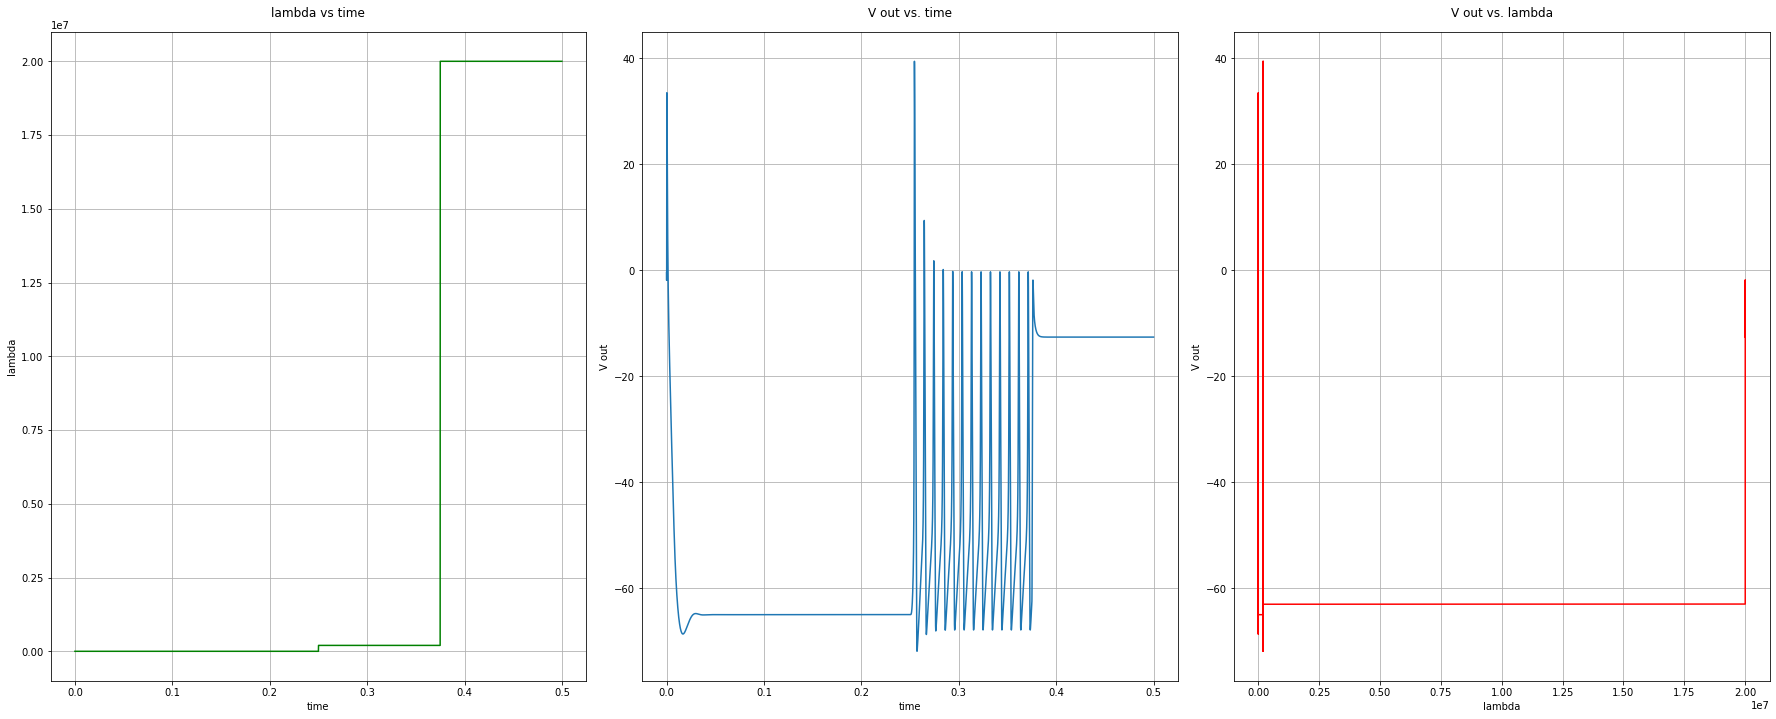

In [14]:
#plot configurations 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(25,10))
fig.tight_layout(pad=2.5)

ax1.plot(t, lmbda, 'g')
ax1.set_title('lambda vs time', pad = 15)
ax1.grid(True)
ax1.set(xlabel = 'time', ylabel = 'lambda')

ax2.plot(t, V_out)
ax2.set_title('V out vs. time', pad = 15)
ax2.grid(True)
ax2.set(xlabel = 'time', ylabel = 'V out')

ax3.plot(lmbda,V_out, 'r')
ax3.set_title('V out vs. lambda', pad = 15)
ax3.grid(True)
ax3.set(xlabel = 'lambda', ylabel = 'V out')